**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# *Exploring the possibilities of music genre classification using MLP* 

Notes: 

1) To run this code install keras, sklearn, pandas, numpy, tensorflow, imbalanced-learn and matplotlib
- pip install -U imbalanced-learn
- pip install keras
- pip install tensorflow

2) Run this code only from top to bottom. If you run the code in a different order you have to run it all again from top to bottom.


## Abstract

In this project I will explore the possibilities to make a MLP classifier that predicts the genre of songs. With different preprocessing techniques and parameters of the MLP I am going to find out if the MLP net can do better than logistic regression. By that we would find if there are nonlinear relations that can be used in the classification. The data used is several preprocessed statistics from several rythm, chroma and mfcc bands. Ultimately I concluded that the data did not contain significant non-linear relations and a model like binomial regression suffices for this particular dataset.



## 1. Introduction


Rythm, chroma and mfcc statistics are a common technique to gather data about songs. These can be used to try and predict data about the songs.

Problem statement: Can a MLP network find non-linear relations in rythm, chroma and mfcc band statistics to improve prediction of songs' genre?

Motivation: If we can predict songs' genres, music services can suggest new songs that do not have any popularity data to users.



## 2. Data analysis

The dimensionality of the data set is quite high. After setting up the first MLP the first task is to find if PCA feature selection can improve the first setup. Because if we can decrease the amount of features we can decrease the amount of nodes, and therefore train better with the small amount of objects. I tried many different ratios responsibility for the total variance and hoped to find results that were better than using all features. This was not the case, we had to keep all the features to get the best results.

The training set was not randomly ordered, many objects from the first class came first in the data set. This does not work well with MLP as it will overfit to that class. We have to shuffle the data set.

The dataset has features with different scales. A MLP will benefit heavily form standardizing the complete dataset. I tried normalizing as well but it had no effect.




In [99]:
# Import libraries
import pandas as pd
from IPython.display import HTML, display
import numpy as np
import keras
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from keras.models import Sequential, load_model
from keras import layers
from keras import regularizers
from keras.layers import Dense, Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import History
from keras.utils import plot_model
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

#...


In [43]:
rawdata = pd.read_csv('..\\all\\train_data.csv', header=None)
test = pd.read_csv( '..\\all\\test_data.csv', header=None)
rawlabels = pd.read_csv('..\\all\\train_labels.csv', header=None)
num_samples = rawdata.shape[0]
train = int(0.8*num_samples)

In [44]:
# Functions that load the data, preprocess the data, and save results of the ML algorithms. 

def load_data():
    
    data,labels = shuffle_training_data(rawdata,rawlabels)

    #datatrain, datatest, labelstest, labelstrain = split_into_train_and_test(data,labels)
    labels = np.ravel(labels)
    data = standardize(data)
    data,labels = smote(data,labels)
    
    #print(data.shape)
    #np.ravel(labels)
    features,pca_data = get_pca_features_data(data,fractions[0]) # tried to find out if the neural network would perform better with pca features only
    return data, labels

def shuffle_training_data (data,labels):
    data = np.matrix(data)
    y = np.ravel(labels)
    datalabel = np.zeros((data.shape[0], data.shape[1]+1))
    datalabel[:, :-1] = data
    datalabel[:, -1] = y
    np.random.shuffle(datalabel)
    data = datalabel[:, :-1]
    #print("Data Shape:",data.shape)
    label = np.transpose(np.matrix(datalabel[:, -1]))
    #print("Label Shape:",label.shape)
    return data,label

def standardize(data):
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(data)
    return scaler.transform(data) #, scaler.transform(datatest)

def normalize(datatrain, datatest):
    scaler = Normalizer().fit(datatrain)
    return scaler.transform(datatrain), scaler.transform(datatest)

def split_into_train_and_test(data,labels):
    labels = labels - 1
    labels = keras.utils.to_categorical(labels, num_classes=10)
    #print(labels.shape)
    #print("labels",labels)
    labelstest = labels[train:num_samples]
    labelstrain = labels[0:train]
    datatest = data[train:num_samples]
    datatrain = data[0:train]
    #datatrain, datatest = normalize(datatrain, datatest)
    return datatrain,datatest,labelstest,labelstrain

def smote(X,y):
    X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X, y)
    #print(sorted(Counter(y_resampled).items()))
    #print(y_resampled.shape)
    y_resampled = np.transpose(np.matrix(y_resampled))
    return X_resampled,y_resampled

def pca(data,fraction_of_variance):
    try:
        eigvalues = np.load('eigvalues.npy')
        eigvectors = np.load('eigvectors.npy')
        print("Matices loaded.")
    except:
        centered_data = data - np.mean(data, axis=0)
        cov_mat = np.cov(centered_data, rowvar=False)
        eigvalues, eigvectors = np.linalg.eig(cov_mat)
        np.save('eigvalues.npy', eigvalues)
        np.save('eigvectors.npy', eigvectors)
 
    eigvalues = eigvalues.real
    #print(eigvalues)
    eigsortedindices = eigvalues.argsort()[::-1]
   
    sum_added_eigvalues,fraction = 0,0

    features = []
    eigvalues = eigvalues.real.tolist()
    eigvallist = enumerate(eigvalues)
    
    total_variability = sum(eigvalues)
    #print(total_variability)
    #sortedeigvallist = sortedeigvalues.tolist()
    sorted_enum_eigvallist = sorted(eigvallist, key=lambda x:x[1])[::-1]
    #print(sorted_enum_eigvallist)
    for index,value in sorted_enum_eigvallist:
        #print(value,total_variability)
        if(fraction < fraction_of_variance):
            features.append(index)
            sum_added_eigvalues = sum_added_eigvalues + value
            fraction = sum_added_eigvalues / total_variability
        else:
            #print(fraction)
            break    
    #print("The following features explain",str(100*fraction) + "% of the variance",features)
    return features, eigvalues

def plot_error(eigvalues,max_d):
    x=range(1,max_d+1)
    errors=[sum(eigvalues[d:]) for d in x]
    plt.plot(x,errors)
    plt.xlabel('Number of principal components $d$')
    plt.ylabel('Reconstruction error $\mathcal{E}$')
    plt.title('Number of principal components vs the reconstruction error')
    plt.show()
    
def get_pca_features_data(data,fraction):
    column_features,eigvalues = pca(data,fraction)
    pca_features_data = np.zeros((data.shape[0],len(column_features)))
    i = 0 
    for feature in column_features:
        pca_features_data[:,i] = data[:,feature]
        i=i+1
    #print("These are the features that explain",str(100*fraction) + "% of the variance according to the principal component analysis:")
    #print("Columns from original data:",column_features)
    #print(pca_features_data)
    return column_features,pca_features_data

def save_result_in_txtfile(score,input_nodes,hidden_nodes):
    report = 'Score: '+str(score)+'. Input nodes: '+str(input_nodes)+'. Hidden Nodes: '+str(hidden_nodes)+'. Optimizer: sgd.'
    fh = open("results_test_different_hidden_nodes.txt","a")
    fh.write(report)
    fh.write("\n")
    fh.close()
    


The fractions were a list of fractions of the variance for calculating the most inportant features responsible for the total variance. It did not help for the predictions so this functionality doesn't work anymore. 

In [45]:
fractions = [1] #0.981,0.982,0.983,0.984,0.985,0.986,0.987,0.988,0.989,0.99,0.991,0.992,0.993,0.994,0.995,0.996,0.997,0.998,0.999,

In [46]:
data, labels = load_data()

datatrain = standardize(data)

features,pca_data = get_pca_features_data(datatrain,fractions[0]) # tried to find out if the neural network would perform better with pca features only

Matices loaded.
Matices loaded.


Means of all features:


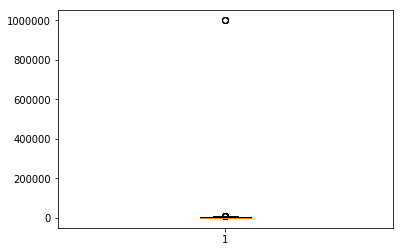

Boxplot of means of all rythm features:


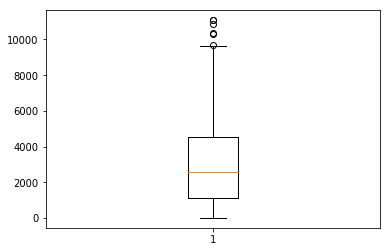

Boxplot of means of all chroma features:


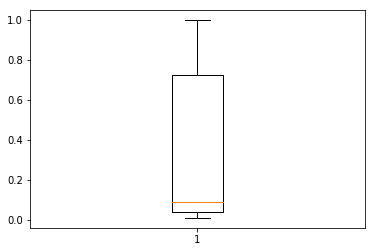

Boxplot of means of all mfcc features:


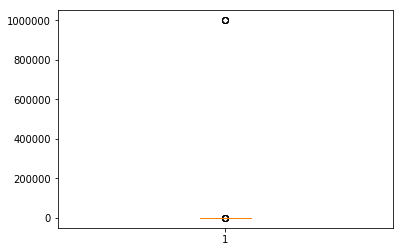

Boxplots of means of all features compared:


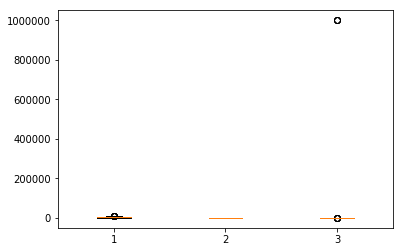

In [47]:
#Analysis of the input data
means = []

for i in range(rawdata.shape[1]):
    #print(i)
    #print(rawdata[i].describe())
    means.append(rawdata[i].mean())

means_rythm = means[0:168]
means_chroma = means[169:216]
means_mfcc = means[216:]

print("Means of all features:")
plt.figure()
plt.hold = True
boxes=[]  
boxes.append(means)
plt.boxplot(boxes,vert=1)
plt.show()

print("Boxplot of means of all rythm features:")
plt.figure()
plt.hold = True
boxes=[]  
boxes.append(means_rythm)
plt.boxplot(boxes,vert=1)
plt.show()

print("Boxplot of means of all chroma features:")
plt.figure()
plt.hold = True
boxes=[]  
boxes.append(means_chroma)
plt.boxplot(boxes,vert=1)
plt.show()

print("Boxplot of means of all mfcc features:")
plt.figure()
plt.hold = True
boxes=[]  
boxes.append(means_mfcc)
plt.boxplot(boxes,vert=1)
plt.show()

print("Boxplots of means of all features compared:")
plt.figure()
plt.hold = True
boxes=[]  
boxes.append(means_rythm)
boxes.append(means_chroma)
boxes.append(means_mfcc)
plt.boxplot(boxes,vert=1)
plt.show()


As you can see the variables differ quite a lot. Standardization will help the MLP to perform better.

In [48]:

print(means_mfcc[0])
print(means_mfcc[1])
print(means_mfcc[2])
print(means_mfcc[3])

1000000.0
1000000.0
1000000.0
1000000.0


In the plots we can see that there is one or more features that do not make sense and should be removed. I print all the feature.describe() to find it (uncomment if you wanna see it). 

The features in the columns 216, 217, 218 and 219 seem to be useless. I will remove them. 

In [49]:
# remove the columns from the data set
rawdata.__delitem__(216)
rawdata.__delitem__(217)
rawdata.__delitem__(218)
rawdata.__delitem__(219)

test.__delitem__(216)
test.__delitem__(217)
test.__delitem__(218)
test.__delitem__(219)

# remove the means from the 
#means_rythm.pop()
means_mfcc = means_mfcc[4:]


In [50]:
print(means_mfcc[1])

-0.010254128997043319


Boxplot of means of all mfcc features:


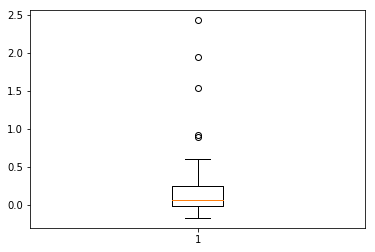

In [97]:
print("Boxplot of means of all mfcc features:")
plt.figure()
plt.hold = True
boxes=[]  
boxes.append(means_mfcc)
plt.boxplot(boxes,vert=1)
plt.show()


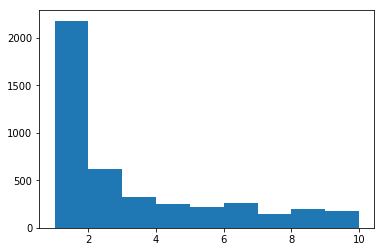

In [52]:
label_list = np.ravel(rawlabels)
plt.hist(label_list, bins=[1, 2, 3,4,5,6,7,8,9,10])
plt.show()

To find out if the training set is unbalanced I plotted the labels. The labes are heavily unbalanced and MLP's will need some adaptation to the model or data to prevent overfitting to the biggest classes. Either changing the weight updats according to the size of the class or some change to the trainingset. I chose for oversampling with the BorderlineSMOTE as it gave the best results. BorderlineSMOTE generates new objects for the unrepresented classes in a way that they won't interfere with the other classes.

## 3. Methods and experiments

*- Explain your whole approach (you can include a block diagram showing the steps in your process).* 

*- What methods/algorithms, why were the methods chosen. *

*- What evaluation methodology (cross CV, etc.).*

- My basic approach was to train many models with the use of loops. By using loops in loops I was able to try many different combinations with different parameters under which: # of hidden nodes, # hidden layers, different amount of best features selected by the pca algorithm, optimizers, amount of dropout nodes, learning rate.
- The MLP without hidden layer functions exactly the same as a logistic regression model. My interest was in adding a hidden layer to see if the MLP network finds non linear relations.
- A problem with MLP nets is that it is relatively prone to overfitting. To solve this problem i had to use the dropout methodology where ever forward propagation the model only will use a part of the nodes of the complete network. Forces the network to look for multiple ways to predict its class. 
- I trained with many different optimizers. Though stochastic gradiend descent performed the best. Especially with a decay dictated by the number of the epoch it is training in a good rate was ensured.
- With a high momentum I was ensured to not find a local minimum.

In [93]:
# Multi layer perceptron

def create_model(lr, input_nodes, hidden_nodes):
    model = Sequential()
    model.add(layers.Dropout(0.2, input_shape=(input_nodes,)))
    model.add(Dense(hidden_nodes, activation='sigmoid'))    # *** You can remove these lines to see how the logistic regressino performs
    model.add(layers.Dropout(0.5))                          # ***
    model.add(Dense(10, activation='softmax'))
    sgd = keras.optimizers.SGD(lr=lr, decay=lr/epochs, momentum=0.8, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(model, datatrain, labelstrain, datatest, labelstest, epochs, i):
    #print(model.summary())
    history = History()
    history = model.fit(datatrain, labelstrain, epochs=epochs, validation_split=0.33,batch_size=28, callbacks=[history],verbose=0)
    score = model.evaluate(datatest, labelstest)
    scores.append([i,[score[0],score[1]]])
    model.save('model_'+str(i)+'.h5')
    #loss = history.history['loss']
    save_result_in_txtfile(score,input_nodes,hidden_nodes)
    #plot_hist(history)
    print("This model has a loss of",score[0],"and a accuracy of",score[1])
    
    return score,scores

def plot_hist(hist):
    # Get training and test loss histories
    training_loss = hist.history['loss']
    test_loss = hist.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

*The parameters below, except input_nodes, can be changed for training. The current setting performed very good.*
*If you want to compare it to the logistic regression model you can remove the hidden layer lines in the model denoted by # ***

In [94]:
# MLP parameters
lr=0.1
epochs = 60
input_nodes = rawdata.shape[1]
print(input_nodes)
hidden_nodes = 260
scores = []


260


*I used K-fold validation to make make sure that the comparison of the models are fair. Sometimes the a model can perform better if it is trained with a training set that happens to work out well for the testing. With k-fold you can prevent that.*

In [95]:
def k_fold_model_creation_and_training(k):
    n_folds = k
    data, labels = load_data()
    skf = StratifiedKFold(n_folds,True)
    i = 1
    for train, test in skf.split(data, labels):
        print("Running Fold "+str(i)+"/"+str(n_folds))
        datatrain, datatest = data[train], data[test]
        labelstrain, labelstest = labels[train], labels[test]
        labelstrain, labelstest = labelstrain - 1, labelstest - 1
        labelstrain,labelstest = keras.utils.to_categorical(labelstrain, num_classes=10),keras.utils.to_categorical(labelstest, num_classes=10)
        model = None # Clearing the NN.
        scores = None
        model = create_model(lr,input_nodes,hidden_nodes)
        score, scores = train_and_evaluate_model(model, datatrain, labelstrain, datatest, labelstest, epochs, i)
        i = i + 1
    print(scores)

C:\Miniconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9149678604224059

In [96]:
# execute training and testing
k_fold_model_creation_and_training(5)

Matices loaded.
Running Fold 1/5
4360/4360 [==============================] - 0s 18us/step
This model has a loss of 1.107732417605339 and a accuracy of 0.6405963302752293
Running Fold 2/5
4360/4360 [==============================] - 0s 18us/step
This model has a loss of 1.0955942489685269 and a accuracy of 0.6302752293577981
Running Fold 3/5
4360/4360 [==============================] - 0s 18us/step
This model has a loss of 1.0975481313302977 and a accuracy of 0.6410550458715596
Running Fold 4/5
4350/4350 [==============================] - 0s 22us/step
This model has a loss of 1.1385156438542507 and a accuracy of 0.6377011494732451
Running Fold 5/5
4350/4350 [==============================] - 0s 28us/step
This model has a loss of 1.1199646554048035 and a a

In [98]:
# !! only used to output the csv files for the kaggle challenges. !!

np.set_printoptions(threshold=10)
model = load_model('model_5.h5')
#print(datatrain.shape,test.shape)
testdata = standardize(test)
output = model.predict(testdata, batch_size=None, verbose=1, steps=None)
sgd = keras.optimizers.SGD(lr=lr, decay=lr/epochs, momentum=0.8, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
sampleid = np.arange(output.shape[0])
sampleid=sampleid+1
#print(sampleid)
matrix = np.ones((output.shape[0],output.shape[1]+1))
matrix[:,0]=sampleid
matrix[:,1:]=output
classes = np.argmax(output,axis=1)
classes = classes+1
np.savetxt("submission.csv", matrix,'%5.4f', delimiter=',', header="Sample_id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10")
matrix2 = np.ones((output.shape[0],2))
matrix2[:,0]=sampleid
matrix2[:,1]=classes
np.savetxt("submission-class.csv", matrix2,'%5.0f', delimiter=',', header="Sample_id,Sample_label")



6544/6544 [==============================] - 0s 60us/step


## 4. Results

*Summarize the results of the experiments without discussing their implications.*

*- Include both performance measures (accuracy and LogLoss).*

*- How does it perform on kaggle compared to the train data.*

*- Include a confusion matrix.*

- See analysis in discussion/conclusion

In [92]:
#Confusion matrix ...
#model.summary()
data,labels = load_data()
output_train = model.predict(data, batch_size=None, verbose=1, steps=None)
#print(output_train.shape)
classes = np.argmax(output_train,axis=1)
pred_labels = classes + 1
cm = confusion_matrix(labels,pred_labels)
cmpd = pd.DataFrame(cm,columns=[str(i+1) for i in range(10)], index=[str(i+1) for i in range(10)])
print("Confusion matrix:")
display(HTML(cmpd.to_html()))
print()
print("K-fold models with loss and accuracy:")
resultsdf = pd.DataFrame(scores)
resultsdf.columns=["Model","Loss, Accuracy"]
display(HTML(resultsdf.to_html()))

Matices loaded.
21780/21780 [==============================] - 0s 20us/step
Confusion matrix:


,1,2,3,4,5,6,7,8,9,10
1,1631,167,34,69,105,111,51,10,0,0
2,125,1920,43,37,21,19,11,1,1,0
3,16,21,2110,15,5,11,0,0,0,0
4,16,12,10,2113,8,18,0,1,0,0
5,103,22,12,46,1955,19,19,2,0,0
6,50,17,33,43,23,2009,3,0,0,0
7,57,34,13,20,47,23,1981,2,0,1
8,982,1,10,23,167,293,44,658,0,0
9,58,143,780,41,279,476,105,0,296,0
10,373,2,12,1251,189,127,83,15,0,126



K-fold models with loss and accuracy:


,Model,"Loss, Accuracy"
0,1,"[1.015345358247057, 0.6674311926605505]"
1,2,"[1.0115077757780706, 0.664908256880734]"
2,3,"[1.0442600248056815, 0.6662844036697247]"
3,4,"[0.9895972582937658, 0.6836781609315297]"
4,5,"[0.9942914174342977, 0.6719540229885057]"


Classes:

1 'Pop_Rock'

2 'Electronic'

3 'Rap'

4 'Jazz'

5 'Latin'

6 'RnB'

7 'International'

8 'Country'

9 'Reggae'

10 'Blues'



## 5. Discussion/Conclusions

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *

- Reggae and Blues are completely mispredicted whereas others get relatively good results. My MLP has big trouble recognizing classes 9 and 10 as an unique genre. 
- On kaggle it performs very well in both the logloss and the accuracy. It will always perform one or two percentage points lower but that is normal as it is impossible to not overfit for a tiny bit. Though, overall it performs very stable and i chose to have one model for both kaggle challenges so I am very happy with the results. 
- I think the oversampling resulted in having a lower accuracy in the smaller classes. On the other hand it made sure that the model is very stable. I think it's a rather good trade-off. Also, the oversampling resulted in being able to train on many more samples (21k samples) as it generates samples for the smaller classes until they are as big as the biggest class. This is the reason why my MLP predicted the bigger classes very well and the smaller classes worse.
- The PCA feature selection that i built in was absolutely useless. My biggest waste of time and effort so far in 2018. I hoped it to be useful for the model to be accurate with a smaller amount of nodes but it was not true. In the end, letting the MLP change the weights within the network and negating some features by itself was much more efficient and gave better results. 
- I think there was barely any improvement of adding the hidden layer. The logistic regression would have worked as well as the MLP with hidden layer. This will partially be the case since we are working with statistics of the actual data. I'm pretty sure that if we had the real data the MLP will work so much better.

**Answer of the problem statement**: The MLP was with the current amount of preprocessing and fixed features selection performing slightly better than the logistic regression model. Though I've seen logistic regression models perform better than my MLP. Therefore the MLP net can make up for some preprocessing that I maybe didn't apply as well as the others did. That is a in a certain way a positive thing of the MLP as it is right now. On the other hand, in my opinion the result were not obvious enough to conclude that the MLP was able to find non linear relations in the data. 

**Future research:** The MLP might be able to find nonlinear relations if we had the actual data instead of the statistics. This is something to be research in the future. Also having more data would be beneficial for the MLP net.  

## 6. References

*List of all the references cited in the document*

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *